<a href="https://colab.research.google.com/github/mratanusarkar/Learning-DeepLearning/blob/main/Neural%20Networks%20-%20Zero%20to%20Hero/building%20micrograd/06.%20codify%20backprop%20-%20implement%20backward%20function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# doing the backpropagation manually every time is ridiculous
# let's put an end to this suffering!
# let's implement backward pass, codify the process and automate it!

In [3]:
# by now, it's pretty obvious to us... how to calculate the grads and the backpropagation
# we should know the local derivative (we saw it for (+), (*) and tanh), 
# and how to flow the grads backwards from right to left

# let's re-write out Value class with new attribute _backward, 
# which will be a function to automate the flow of the grads for each node and operation

In [4]:
# updated micrograd Value class with _backward

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.label = label  # optional, Value variable/node name
        self.grad = 0.0     # initially, the grad be zero (means no effect on output)

        # internal variables used for autograd graph construction
        self._prev = set(_children)     # previous node
        self._op = _op                  # the operation that produced this node
        self._backward = lambda: None   # to do the little piece of chain rule at each local node, backwards
                                        # by default _backward is None, as there is nothing to do at a leaf node

    def __repr__(self):
        return f"Value(label={self.label if self.label else 'None'}, data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # local derivative (= 1.0) * out's grad
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # local derivative (= switching the data of leaf nodes) * out's grad
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # local derivative of tanh (1 - tanh(x)**2) * out's grad
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out


In [5]:
# import visualization functions to show grads

from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data: %.4f | grad: %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


In [6]:
# let's see how it works with out neuron example from the last notebook

In [7]:
# let's start writing an expression for our neuron with two inputs: x1 and x2

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')    # setting a weird value, as it will help in calculation down the line!

# dendrites of the neuron (inputs weighted)
den1 = x1 * w1;     den1.label='den1'
den2 = x2 * w2;     den2.label='den2'

# sum of dendrite signals inside cell body
sum = den1 + den2;  sum.label='sum'

# bias gets added inside the body
body = sum + b;     body.label='body'

# the net signal passes through an activation function to give output
out = body.tanh();  out.label='out'

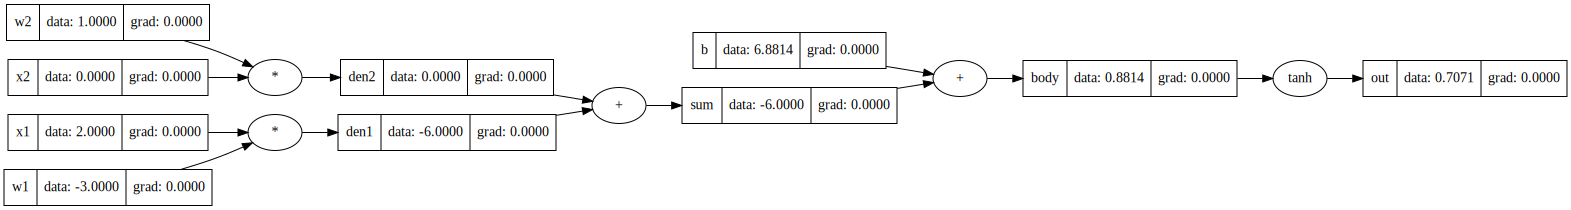

In [8]:
draw_dot(out)

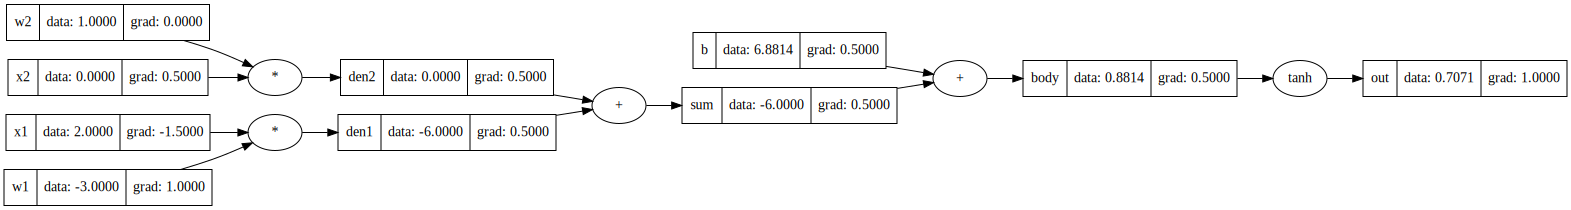

In [9]:
# so now, instead of manually updating the grads, we have to call _backward in the right order

# as a base case, we have to set out's grad to 1.0
out.grad = 1.0

# and rest of the backward pass (backpropagation) will be taken care by calling _backward "in the right order"
out._backward()

body._backward()

b._backward()       # nothing would happen as b is a leaf node, and it doesn't have a _backward!
sum._backward()

den2._backward()
den1._backward()

w2._backward()      # nothing would happen as it's a leaf node
x2._backward()      # nothing would happen as it's a leaf node
w1._backward()      # nothing would happen as it's a leaf node
x1._backward()      # nothing would happen as it's a leaf node

# let's see the result
draw_dot(out)

In [10]:
# and we get the same result! but this time the calculations and local backward pass was taken care by _backward() !!

In [11]:
# let's go a step further and automate the whole process for the entire expression graph and let it figure out the order by itself too!
# we won't call _backward() ourselves anymore! let's automate that too!

In [12]:
# so, we have laid out a mathematical expression, and we are trying to go back through that expression
# and we don't want to call _backward() for any node before everything after it! LoL
# in simple terms, if a -> b -> c is our expresion, we shouldn't call a._backward() until b._backward() is called, ... and so on...

In [13]:
# this ordering of graphs can be achieved through something called "topological sort"
# topological sort is basically laying out of a graph such that all the edges go only from left to right

# definition: Topological sorting for a Graph is a linear ordering of vertices such that for every directed edge u v, vertex u comes before v in the ordering.
# https://en.wikipedia.org/wiki/Topological_sorting
# https://www.geeksforgeeks.org/topological-sorting/

![topological-sort.png](https://assets.leetcode.com/users/images/63bd7ad6-403c-42f1-b8bb-2ea41e42af9a_1613794080.8115625.png)

![topological-sort.png](https://miro.medium.com/v2/resize:fit:1200/1*uMg_ojFXts2WZSjcZe4oRQ.png)

In [14]:
def topological_sort(node):
    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(node)
    return topo

In [15]:
topological_sort(out)

[Value(label=w1, data=-3.0),
 Value(label=x1, data=2.0),
 Value(label=den1, data=-6.0),
 Value(label=w2, data=1.0),
 Value(label=x2, data=0.0),
 Value(label=den2, data=0.0),
 Value(label=sum, data=-6.0),
 Value(label=b, data=6.881373587019543),
 Value(label=body, data=0.8813735870195432),
 Value(label=out, data=0.7071067811865476)]

In [16]:
# now let's use the same to automate calling the _backward() !!

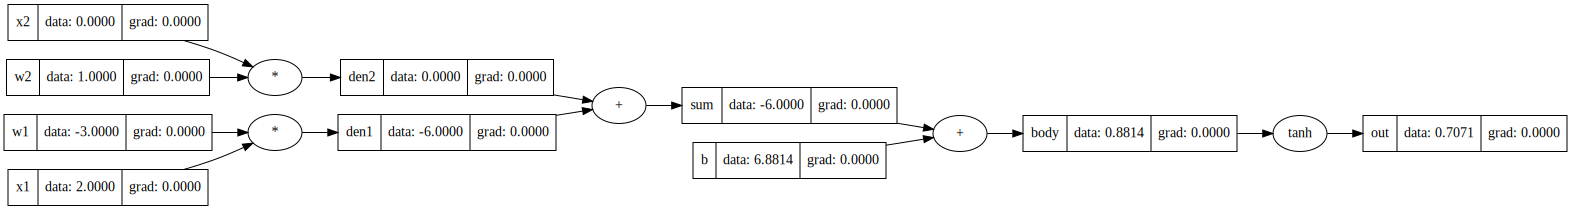

In [17]:
# let's reset the grads
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
den1 = x1 * w1;     den1.label='den1'
den2 = x2 * w2;     den2.label='den2'
sum = den1 + den2;  sum.label='sum'
body = sum + b;     body.label='body'
out = body.tanh();  out.label='out'

# let's take a look
draw_dot(out)

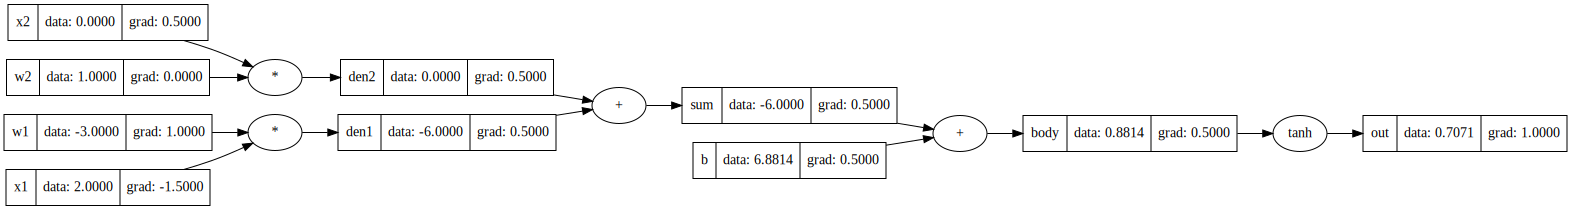

In [18]:
# now let's automate filling in the grads

# base case
out.grad = 1.0

# then we build the topological order
topo = topological_sort(out)

# and then traverse backwards, calling _backward() on the way
for node in reversed(topo):
    node._backward()

# let's see the result
draw_dot(out)

In [19]:
# and... BOOM! it's done!

In [20]:
# let's redefine our Value class hiding this inside a backward() function:

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.label = label  # optional, Value variable/node name
        self.grad = 0.0     # initially, the grad be zero (means no effect on output)

        # internal variables used for autograd graph construction
        self._prev = set(_children)     # previous node
        self._op = _op                  # the operation that produced this node
        self._backward = lambda: None   # to do the little piece of chain rule at each local node, backwards
                                        # by default _backward is None, as there is nothing to do at a leaf node

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # local derivative (= 1.0) * out's grad
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # local derivative (= switching the data of leaf nodes) * out's grad
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # local derivative of tanh (1 - tanh(x)**2) * out's grad
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        # our topological sort function
        def topological_sort(node):
            topo = []
            visited = set()
            def build_topo(v):
                if v not in visited:
                    visited.add(v)
                    for child in v._prev:
                        build_topo(child)
                    topo.append(v)
            build_topo(node)
            return topo

        # base case
        self.grad = 1.0

        # and then traverse backwards, calling _backward() on the way
        for node in reversed(topological_sort(self)):
            node._backward()

In [21]:
# let's test it out

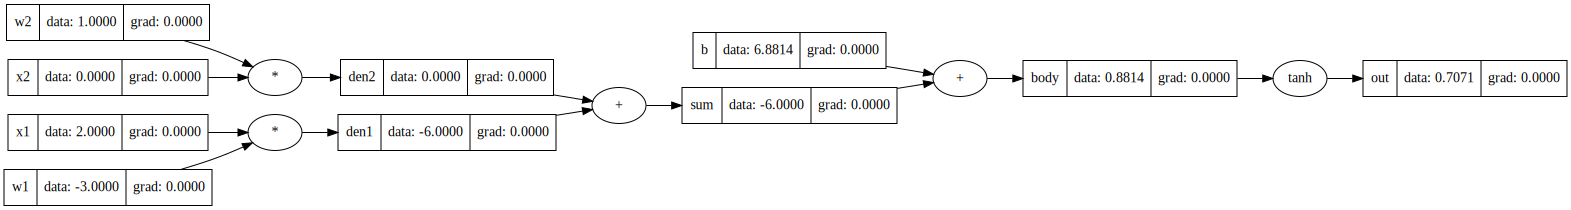

In [22]:
# let's reset the grads
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
den1 = x1 * w1;     den1.label='den1'
den2 = x2 * w2;     den2.label='den2'
sum = den1 + den2;  sum.label='sum'
body = sum + b;     body.label='body'
out = body.tanh();  out.label='out'

# let's take a look
draw_dot(out)

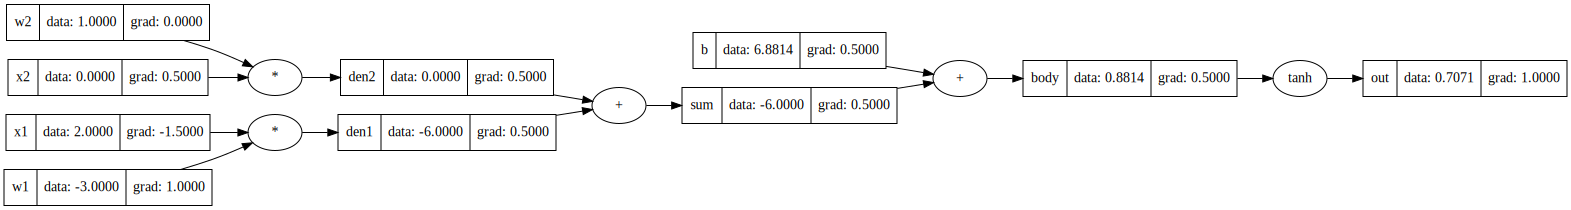

In [23]:
out.backward()
draw_dot(out)

In [24]:
# there we go!! and that's backpropagation!! (for one neuron)